## Imports

In [1]:
# referenced https://srush.github.io/annotated-s4/#part-1b-addressing-long-range-dependencies-with-hippo

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

import numpy as np

## Random SSM

In [2]:
class RandomSSM(nn.Module):
    def __init__(self, N, num_channels, fixed_length=10, A=None, B=None, C=None):
        super(RandomSSM, self).__init__()

        # maps time series output to previous timestep N-dim latent state and projects back to output time series data
        if A is None:
            A = torch.randn((N, N))
        if B is None:
            B = torch.randn((N, 1))

        self.N = N
        self.num_channels = num_channels

        # assuming fixed length sequences
        self.A, self.B, self.C = self.discretize(A, B, C, step=1.0/fixed_length)

    def forward(self, u):
        x = torch.zeros((u.shape[0], u.shape[1]+1, self.N))
        
        # u shape - B, T, C
        # recurrency via iteration
        for channel in range(u.shape[-1]):      # for proper mapping shape broadcasting
            for timestep in range(u.shape[1]):
                x[:, timestep+1] = (self.A(x[:, timestep]).view(-1, self.N)
                    + self.B(u[:, timestep, channel].view(-1, 1))).view(-1, self.N)
        
        # final projection back to proper time series data
        y = self.C(x[:, 1:])
        
        return y

    def discretize(self, A, B, C=None, step=1):
        identity_matrix = torch.eye(self.N)

        # discretize via bilinear transform https://en.wikipedia.org/wiki/Bilinear_transform
        BL = torch.inverse(identity_matrix - (step / 2.0) * A)
        A_discrete = BL @ (identity_matrix + (step / 2.0) * A)
        B_discrete = (BL * step) @ B

        A_final = nn.Linear(*A.shape, bias=False)
        A_final.weight = nn.Parameter(A_discrete)
        B_final = nn.Linear(*B.shape, bias=False)
        B_final.weight = nn.Parameter(B_discrete)

        # allows for conditional initialization of C
        if C is None:
            C_final = nn.Linear(self.N, self.num_channels, bias=False)
        else:
            C_final = nn.Linear(*C.shape, bias=False)
            C_final.weight = nn.Parameter(C)

        return A_final, B_final, C_final

In [3]:
N = 50
timesteps = 10
num_channels = 8

# test 1
model = RandomSSM(N, num_channels, timesteps)

input_signal = torch.randn((4, timesteps, num_channels))
print(f'Input signal shape: {input_signal.shape}')

output_signal = model(input_signal)
print(f'Output signal shape: {output_signal.shape}\n')

# test 2
A = torch.randn((N, N))
B = torch.randn((N, 1))
C = torch.randn((num_channels, N))

model = RandomSSM(N, num_channels, timesteps, A, B, C)

input_signal = torch.randn((4, timesteps, num_channels))
print(f'Input signal shape: {input_signal.shape}')

output_signal = model(input_signal)
print(f'Output signal shape: {output_signal.shape}')

Input signal shape: torch.Size([4, 10, 8])
Output signal shape: torch.Size([4, 10, 8])

Input signal shape: torch.Size([4, 10, 8])
Output signal shape: torch.Size([4, 10, 8])


## Mass example

In [4]:
def example_mass(k, b, m):
    A = torch.tensor([[0, 1], [-k / m, -b / m]])
    B = torch.tensor([[0], [1.0 / m]])
    C = torch.tensor([[1.0, 0]])
    
    return A, B, C

def example_force(t):
    x = torch.sin(10 * t)
    return x * (x > 0.5)

In [5]:
A, B, C = example_mass(k=40, b=5, m=1)

L = 100
step = 1.0 / L
ks = torch.arange(L)
u = example_force(ks * step)

# Approximation of y(t).
model = RandomSSM(2, 1, L, A, B, C)

input_signal = u.view(1, -1, 1)
print(f'Input signal shape: {input_signal.shape}')

output_signal = model(input_signal)
print(f'Output signal shape: {output_signal.shape}')

Input signal shape: torch.Size([1, 100, 1])
Output signal shape: torch.Size([1, 100, 1])


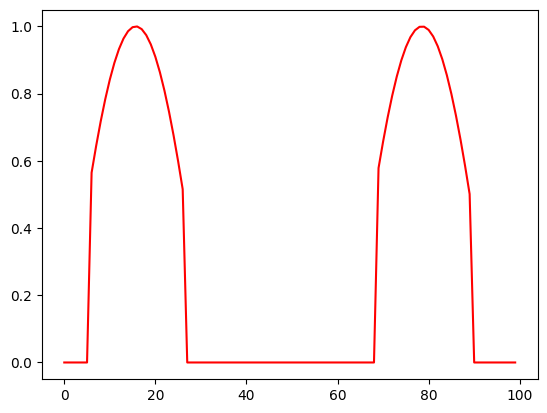

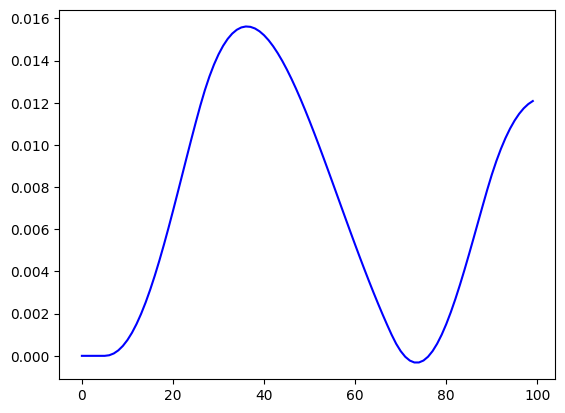

In [8]:
plt.figure()
plt.plot(ks, u.view(-1).numpy(), color="red")
plt.figure()
plt.plot(ks, output_signal.view(-1).detach().numpy(), color="blue")